In [1]:
%pip install -q "torch>=2.1" torchvision "diffusers==0.25.1" "peft==0.6.2" transformers tqdm pillow gradio opencv-python "gradio==3.43.1" --extra-index-url https://download.pytorch.org/whl/cpu

In [2]:
from pathlib import Path

repo_dir = Path("img2img-turbo")

if not repo_dir.exists():
    !git clone https://github.com/GaParmar/img2img-turbo.git

pix2pix_turbo_py_path = repo_dir / "src/pix2pix_turbo.py"
model_py_path = repo_dir / "src/model.py"
orig_pix2pix_turbo_path = pix2pix_turbo_py_path.parent / ("orig_" + pix2pix_turbo_py_path.name)
orig_model_py_path = model_py_path.parent / ("orig_" + model_py_path.name)

if not orig_pix2pix_turbo_path.exists():
    pix2pix_turbo_py_path.rename(orig_pix2pix_turbo_path)

    with orig_pix2pix_turbo_path.open("r") as f:
        data = f.read()
        data = data.replace("cuda", "cpu")
        with pix2pix_turbo_py_path.open("w") as out_f:
            out_f.write(data)

if not orig_model_py_path.exists():
    model_py_path.rename(orig_model_py_path)

    with orig_model_py_path.open("r") as f:
        data = f.read()
        data = data.replace("cuda", "cpu")
        with model_py_path.open("w") as out_f:
            out_f.write(data)
%cd $repo_dir

/home/ea/work/openvino_notebooks/notebooks/sketch-to-image-pix2pix-turbo/img2img-turbo


In [3]:
import os
import requests
import sys
import copy
from tqdm import tqdm
import torch
from transformers import AutoTokenizer, CLIPTextModel
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers.models.autoencoders.vae import DiagonalGaussianDistribution
from diffusers.utils.peft_utils import set_weights_and_activate_adapters
from peft import LoraConfig
import types

from src.model import make_1step_sched
from src.pix2pix_turbo import TwinConv

tokenizer = AutoTokenizer.from_pretrained("stabilityai/sd-turbo", subfolder="tokenizer")


def tokenize_prompt(prompt):
    caption_tokens = tokenizer(prompt, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt").input_ids
    return caption_tokens

def _vae_encoder_fwd(self, sample):
    sample = self.conv_in(sample)
    l_blocks = []
    # down
    for down_block in self.down_blocks:
        l_blocks.append(sample)
        sample = down_block(sample)
    # middle
    sample = self.mid_block(sample)
    sample = self.conv_norm_out(sample)
    sample = self.conv_act(sample)
    sample = self.conv_out(sample)
    current_down_blocks = l_blocks
    return sample, current_down_blocks


def _vae_decoder_fwd(self, sample, incoming_skip_acts, latent_embeds=None):
    sample = self.conv_in(sample)
    upscale_dtype = next(iter(self.up_blocks.parameters())).dtype
    # middle
    sample = self.mid_block(sample, latent_embeds)
    sample = sample.to(upscale_dtype)
    if not self.ignore_skip:
        skip_convs = [self.skip_conv_1, self.skip_conv_2, self.skip_conv_3, self.skip_conv_4]
        # up
        for idx, up_block in enumerate(self.up_blocks):
            skip_in = skip_convs[idx](incoming_skip_acts[::-1][idx] * self.gamma)
            # add skip
            sample = sample + skip_in
            sample = up_block(sample, latent_embeds)
    else:
        for idx, up_block in enumerate(self.up_blocks):
            sample = up_block(sample, latent_embeds)
    # post-process
    if latent_embeds is None:
        sample = self.conv_norm_out(sample)
    else:
        sample = self.conv_norm_out(sample, latent_embeds)
    sample = self.conv_act(sample)
    sample = self.conv_out(sample)
    return sample

def vae_encode(self, x: torch.FloatTensor):
    """
    Encode a batch of images into latents.

    Args:
        x (`torch.FloatTensor`): Input batch of images.

    Returns:
        The latent representations of the encoded images. If `return_dict` is True, a
        [`~models.autoencoder_kl.AutoencoderKLOutput`] is returned, otherwise a plain `tuple` is returned.
        """
    h, down_blocks = self.encoder(x)

    moments = self.quant_conv(h)
    posterior = DiagonalGaussianDistribution(moments)

    return (posterior, down_blocks)

    
def vae_decode(self, z: torch.FloatTensor, skip_acts):
    decoded = self._decode(z, skip_acts)[0]
    return (decoded,)

def vae__decode(self, z: torch.FloatTensor, skip_acts):
    z = self.post_quant_conv(z)
    dec = self.decoder(z, skip_acts)

    return (dec,)

class Pix2PixTurbo(torch.nn.Module):
    def __init__(self, pretrained_name=None, pretrained_path=None, ckpt_folder="checkpoints", lora_rank_unet=8, lora_rank_vae=4):
        super().__init__()
        self.text_encoder = CLIPTextModel.from_pretrained("stabilityai/sd-turbo", subfolder="text_encoder").cpu()
        self.sched = make_1step_sched()

        vae = AutoencoderKL.from_pretrained("stabilityai/sd-turbo", subfolder="vae")
        vae.encoder.forward = types.MethodType(_vae_encoder_fwd, vae.encoder)
        vae.decoder.forward = types.MethodType(_vae_decoder_fwd, vae.decoder)
        vae.encode = types.MethodType(vae_encode, vae)
        vae.decode = types.MethodType(vae_decode, vae)
        vae._decode = types.MethodType(vae__decode, vae)
        # add the skip connection convs
        vae.decoder.skip_conv_1 = torch.nn.Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1), bias=False).cpu()
        vae.decoder.skip_conv_2 = torch.nn.Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1), bias=False).cpu()
        vae.decoder.skip_conv_3 = torch.nn.Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False).cpu()
        vae.decoder.skip_conv_4 = torch.nn.Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False).cpu()
        vae.decoder.ignore_skip = False
        unet = UNet2DConditionModel.from_pretrained("stabilityai/sd-turbo", subfolder="unet")

        if pretrained_name == "edge_to_image":
            url = "https://www.cs.cmu.edu/~img2img-turbo/models/edge_to_image_loras.pkl"
            os.makedirs(ckpt_folder, exist_ok=True)
            outf = os.path.join(ckpt_folder, "edge_to_image_loras.pkl")
            if not os.path.exists(outf):
                print(f"Downloading checkpoint to {outf}")
                response = requests.get(url, stream=True)
                total_size_in_bytes = int(response.headers.get('content-length', 0))
                block_size = 1024  # 1 Kibibyte
                progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
                with open(outf, 'wb') as file:
                    for data in response.iter_content(block_size):
                        progress_bar.update(len(data))
                        file.write(data)
                progress_bar.close()
                if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
                    print("ERROR, something went wrong")
                print(f"Downloaded successfully to {outf}")
            p_ckpt = outf
            sd = torch.load(p_ckpt, map_location="cpu")
            unet_lora_config = LoraConfig(r=sd["rank_unet"], init_lora_weights="gaussian", target_modules=sd["unet_lora_target_modules"])
            vae_lora_config = LoraConfig(r=sd["rank_vae"], init_lora_weights="gaussian", target_modules=sd["vae_lora_target_modules"])
            vae.add_adapter(vae_lora_config, adapter_name="vae_skip")
            _sd_vae = vae.state_dict()
            for k in sd["state_dict_vae"]:
                _sd_vae[k] = sd["state_dict_vae"][k]
            vae.load_state_dict(_sd_vae)
            unet.add_adapter(unet_lora_config)
            _sd_unet = unet.state_dict()
            for k in sd["state_dict_unet"]:
                _sd_unet[k] = sd["state_dict_unet"][k]
            unet.load_state_dict(_sd_unet)

        elif pretrained_name == "sketch_to_image_stochastic":
            # download from url
            url = "https://www.cs.cmu.edu/~img2img-turbo/models/sketch_to_image_stochastic_lora.pkl"
            os.makedirs(ckpt_folder, exist_ok=True)
            outf = Path(ckpt_folder) / "sketch_to_image_stochastic_lora.pkl"
            if not outf.exists():
                print(f"Downloading checkpoint to {outf}")
                response = requests.get(url, stream=True)
                total_size_in_bytes = int(response.headers.get('content-length', 0))
                block_size = 1024  # 1 Kibibyte
                progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
                with open(outf, 'wb') as file:
                    for data in response.iter_content(block_size):
                        progress_bar.update(len(data))
                        file.write(data)
                progress_bar.close()
                if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
                    print("ERROR, something went wrong")
                print(f"Downloaded successfully to {outf}")
            p_ckpt = outf
            convin_pretrained = copy.deepcopy(unet.conv_in)
            unet.conv_in = TwinConv(convin_pretrained, unet.conv_in)
            sd = torch.load(p_ckpt, map_location="cpu")
            unet_lora_config = LoraConfig(r=sd["rank_unet"], init_lora_weights="gaussian", target_modules=sd["unet_lora_target_modules"])
            vae_lora_config = LoraConfig(r=sd["rank_vae"], init_lora_weights="gaussian", target_modules=sd["vae_lora_target_modules"])
            vae.add_adapter(vae_lora_config, adapter_name="vae_skip")
            _sd_vae = vae.state_dict()
            for k in sd["state_dict_vae"]:
                if k not in _sd_vae:
                    continue
                _sd_vae[k] = sd["state_dict_vae"][k]

            vae.load_state_dict(_sd_vae)
            unet.add_adapter(unet_lora_config)
            _sd_unet = unet.state_dict()
            for k in sd["state_dict_unet"]:
                _sd_unet[k] = sd["state_dict_unet"][k]
            unet.load_state_dict(_sd_unet)

        elif pretrained_path is not None:
            sd = torch.load(pretrained_path, map_location="cpu")
            unet_lora_config = LoraConfig(r=sd["rank_unet"], init_lora_weights="gaussian", target_modules=sd["unet_lora_target_modules"])
            vae_lora_config = LoraConfig(r=sd["rank_vae"], init_lora_weights="gaussian", target_modules=sd["vae_lora_target_modules"])
            vae.add_adapter(vae_lora_config, adapter_name="vae_skip")
            _sd_vae = vae.state_dict()
            for k in sd["state_dict_vae"]:
                _sd_vae[k] = sd["state_dict_vae"][k]
            vae.load_state_dict(_sd_vae)
            unet.add_adapter(unet_lora_config)
            _sd_unet = unet.state_dict()
            for k in sd["state_dict_unet"]:
                _sd_unet[k] = sd["state_dict_unet"][k]
            unet.load_state_dict(_sd_unet)

        # unet.enable_xformers_memory_efficient_attention()
        unet.to("cpu")
        vae.to("cpu")
        self.unet, self.vae = unet, vae
        self.vae.decoder.gamma = 1
        self.timesteps = torch.tensor([999], device="cpu").long()
        self.text_encoder.requires_grad_(False)

    def set_r(self, r):
        self.unet.set_adapters(["default"], weights=[r])
        set_weights_and_activate_adapters(self.vae, ["vae_skip"], [r])
        self.r = r
        self.unet.conv_in.r = r
        self.vae.decoder.gamma = r
        

    def forward(self, c_t, prompt_tokens, noise_map):
        caption_enc = self.text_encoder(prompt_tokens)[0]
        # scale the lora weights based on the r value
        sample, current_down_blocks = self.vae.encode(c_t)
        encoded_control = sample.sample() * self.vae.config.scaling_factor
        # combine the input and noise
        unet_input = encoded_control * self.r + noise_map * (1 - self.r)
            
        unet_output = self.unet(unet_input, self.timesteps, encoder_hidden_states=caption_enc,).sample
        x_denoised = self.sched.step(unet_output, self.timesteps, unet_input, return_dict=True).prev_sample
        output_image = (self.vae.decode(x_denoised / self.vae.config.scaling_factor, current_down_blocks)[0]).clamp(-1, 1)
        return output_image


/home/ea/work/my_optimum_intel/optimum_env/lib/python3.8/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


/home/ea/work/my_optimum_intel/optimum_env/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32


2024-05-02 18:48:47.607304: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-02 18:48:47.609104: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-02 18:48:47.643578: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-02 18:48:47.644677: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-02 18:48:48.268888: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [4]:
ov_model_path = Path("model/pix2pix-turbo.xml")

pt_model = None

if not ov_model_path.exists():
    pt_model = Pix2PixTurbo("sketch_to_image_stochastic")
    pt_model.set_r(0.4)
    pt_model.eval()

In [5]:
import gc
import openvino as ov

if not ov_model_path.exists():
    example_input = [torch.ones((1, 3, 512, 512)), torch.ones([1, 77], dtype=torch.int64), torch.ones([1, 4, 64, 64])]
    with torch.no_grad():
        ov_model = ov.convert_model(pt_model, example_input=example_input, input=[[1, 3, 512, 512], [1, 77], [1, 4, 64, 64]])
        ov.save_model(ov_model, ov_model_path)
    del ov_model
    torch._C._jit_clear_class_registry()
    torch.jit._recursive.concrete_type_store = torch.jit._recursive.ConcreteTypeStore()
    torch.jit._state._clear_class_state()
del pt_model
gc.collect();

In [6]:
import ipywidgets as widgets

core = ov.Core()
device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="AUTO",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='AUTO')

In [7]:
compiled_model = core.compile_model(ov_model_path, device.value)

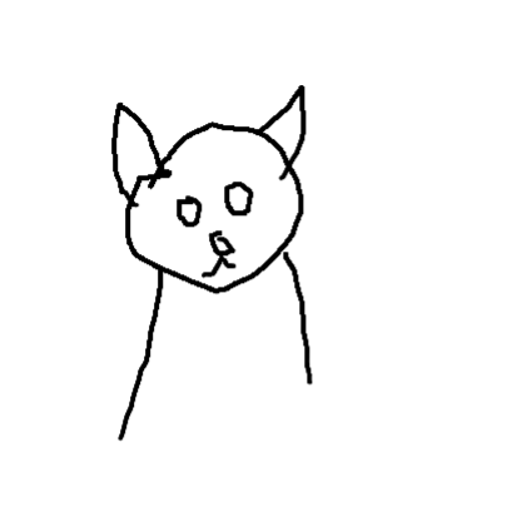

In [8]:
from PIL import Image
import numpy as np

sketch_image = Image.open("/home/ea/Downloads/sketch(5).png")

sketch_image

In [9]:
import torchvision.transforms.functional as F

torch.manual_seed(145)
c_t = torch.unsqueeze(F.to_tensor(sketch_image) > 0.5, 0)
noise = torch.randn((1, 4, 512 // 8, 512 // 8))

In [10]:
prompt_template = "anime artwork {prompt} . anime style, key visual, vibrant, studio anime,  highly detailed"
prompt = prompt_template.replace("{prompt}", "fluffy  magic cat")

prompt_tokens = tokenize_prompt(prompt)

In [11]:
result = compiled_model([1 - c_t.to(torch.float32), prompt_tokens, noise])[0]

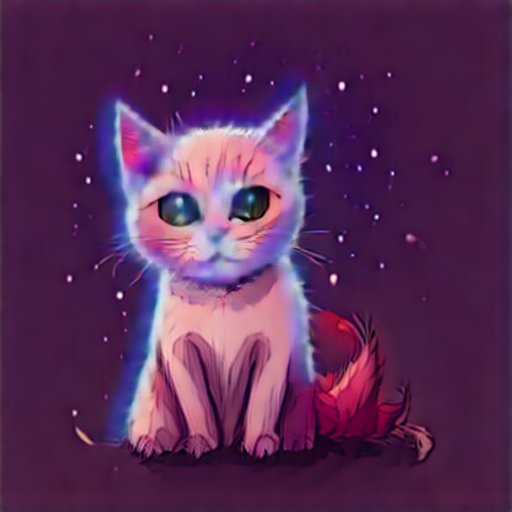

In [12]:
import numpy as np

image_tensor = (result[0] * 0.5 + 0.5) * 255
image = np.transpose(image_tensor, (1, 2, 0)).astype(np.uint8)
Image.fromarray(image)

In [ ]:
import random
import base64
from io import BytesIO
import gradio as gr

style_list = [
    {
        "name": "Cinematic",
        "prompt": "cinematic still {prompt} . emotional, harmonious, vignette, highly detailed, high budget, bokeh, cinemascope, moody, epic, gorgeous, film grain, grainy",
    },
    {
        "name": "3D Model",
        "prompt": "professional 3d model {prompt} . octane render, highly detailed, volumetric, dramatic lighting",
    },
    {
        "name": "Anime",
        "prompt": "anime artwork {prompt} . anime style, key visual, vibrant, studio anime,  highly detailed",
    },
    {
        "name": "Digital Art",
        "prompt": "concept art {prompt} . digital artwork, illustrative, painterly, matte painting, highly detailed",
    },
    {
        "name": "Photographic",
        "prompt": "cinematic photo {prompt} . 35mm photograph, film, bokeh, professional, 4k, highly detailed",
    },
    {
        "name": "Pixel art",
        "prompt": "pixel-art {prompt} . low-res, blocky, pixel art style, 8-bit graphics",
    },
    {
        "name": "Fantasy art",
        "prompt": "ethereal fantasy concept art of  {prompt} . magnificent, celestial, ethereal, painterly, epic, majestic, magical, fantasy art, cover art, dreamy",
    },
    {
        "name": "Neonpunk",
        "prompt": "neonpunk style {prompt} . cyberpunk, vaporwave, neon, vibes, vibrant, stunningly beautiful, crisp, detailed, sleek, ultramodern, magenta highlights, dark purple shadows, high contrast, cinematic, ultra detailed, intricate, professional",
    },
    {
        "name": "Manga",
        "prompt": "manga style {prompt} . vibrant, high-energy, detailed, iconic, Japanese comic style",
    },
]

styles = {k["name"]: k["prompt"] for k in style_list}
STYLE_NAMES = list(styles.keys())
DEFAULT_STYLE_NAME = "Fantasy art"
MAX_SEED = np.iinfo(np.int32).max


def pil_image_to_data_uri(img, format="PNG"):
    buffered = BytesIO()
    img.save(buffered, format=format)
    img_str = base64.b64encode(buffered.getvalue()).decode()
    return f"data:image/{format.lower()};base64,{img_str}"


def run(image, prompt, prompt_template, style_name, seed):
    print(f"prompt: {prompt}")
    print("sketch updated")
    if image is None:
        ones = Image.new("L", (512, 512), 255)
        temp_uri = pil_image_to_data_uri(ones)
        return ones, gr.update(link=temp_uri), gr.update(link=temp_uri)
    prompt = prompt_template.replace("{prompt}", prompt)
    image = image.convert("RGB")
    image_t = F.to_tensor(image) > 0.5
    print(f"seed={seed}")
    caption_tokens = tokenizer(prompt, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt").input_ids.cpu()
    with torch.no_grad():
        c_t = image_t.unsqueeze(0)
        torch.manual_seed(seed)
        B, C, H, W = c_t.shape
        noise = torch.randn((1, 4, H // 8, W // 8))
        output_image = torch.from_numpy(compiled_model([c_t.to(torch.float32), caption_tokens, noise])[0])
    output_pil = F.to_pil_image(output_image[0].cpu() * 0.5 + 0.5)
    input_sketch_uri = pil_image_to_data_uri(Image.fromarray(255 - np.array(image)))
    output_image_uri = pil_image_to_data_uri(output_pil)
    return (
        output_pil,
        gr.update(link=input_sketch_uri),
        gr.update(link=output_image_uri),
    )


def update_canvas(use_line, use_eraser):
    if use_eraser:
        _color = "#ffffff"
        brush_size = 20
    if use_line:
        _color = "#000000"
        brush_size = 4
    return gr.update(brush_radius=brush_size, brush_color=_color, interactive=True)


def upload_sketch(file):
    _img = Image.open(file.name)
    _img = _img.convert("L")
    return gr.update(value=_img, source="upload", interactive=True)


scripts = """
async () => {
    globalThis.theSketchDownloadFunction = () => {
        console.log("test")
        var link = document.createElement("a");
        dataUri = document.getElementById('download_sketch').href
        link.setAttribute("href", dataUri)
        link.setAttribute("download", "sketch.png")
        document.body.appendChild(link); // Required for Firefox
        link.click();
        document.body.removeChild(link); // Clean up

        // also call the output download function
        theOutputDownloadFunction();
      return false
    }

    globalThis.theOutputDownloadFunction = () => {
        console.log("test output download function")
        var link = document.createElement("a");
        dataUri = document.getElementById('download_output').href
        link.setAttribute("href", dataUri);
        link.setAttribute("download", "output.png");
        document.body.appendChild(link); // Required for Firefox
        link.click();
        document.body.removeChild(link); // Clean up
      return false
    }

    globalThis.UNDO_SKETCH_FUNCTION = () => {
        console.log("undo sketch function")
        var button_undo = document.querySelector('#input_image > div.image-container.svelte-p3y7hu > div.svelte-s6ybro > button:nth-child(1)');
        // Create a new 'click' event
        var event = new MouseEvent('click', {
            'view': window,
            'bubbles': true,
            'cancelable': true
        });
        button_undo.dispatchEvent(event);
    }

    globalThis.DELETE_SKETCH_FUNCTION = () => {
        console.log("delete sketch function")
        var button_del = document.querySelector('#input_image > div.image-container.svelte-p3y7hu > div.svelte-s6ybro > button:nth-child(2)');
        // Create a new 'click' event
        var event = new MouseEvent('click', {
            'view': window,
            'bubbles': true,
            'cancelable': true
        });
        button_del.dispatchEvent(event);
    }

    globalThis.togglePencil = () => {
        el_pencil = document.getElementById('my-toggle-pencil');
        el_pencil.classList.toggle('clicked');
        // simulate a click on the gradio button
        btn_gradio = document.querySelector("#cb-line > label > input");
        var event = new MouseEvent('click', {
            'view': window,
            'bubbles': true,
            'cancelable': true
        });
        btn_gradio.dispatchEvent(event);
        if (el_pencil.classList.contains('clicked')) {
            document.getElementById('my-toggle-eraser').classList.remove('clicked');
            document.getElementById('my-div-pencil').style.backgroundColor = "gray";
            document.getElementById('my-div-eraser').style.backgroundColor = "white";
        }
        else {
            document.getElementById('my-toggle-eraser').classList.add('clicked');
            document.getElementById('my-div-pencil').style.backgroundColor = "white";
            document.getElementById('my-div-eraser').style.backgroundColor = "gray";
        }
    }

    globalThis.toggleEraser = () => {
        element = document.getElementById('my-toggle-eraser');
        element.classList.toggle('clicked');
        // simulate a click on the gradio button
        btn_gradio = document.querySelector("#cb-eraser > label > input");
        var event = new MouseEvent('click', {
            'view': window,
            'bubbles': true,
            'cancelable': true
        });
        btn_gradio.dispatchEvent(event);
        if (element.classList.contains('clicked')) {
            document.getElementById('my-toggle-pencil').classList.remove('clicked');
            document.getElementById('my-div-pencil').style.backgroundColor = "white";
            document.getElementById('my-div-eraser').style.backgroundColor = "gray";
        }
        else {
            document.getElementById('my-toggle-pencil').classList.add('clicked');
            document.getElementById('my-div-pencil').style.backgroundColor = "gray";
            document.getElementById('my-div-eraser').style.backgroundColor = "white";
        }
    }
}
"""

with gr.Blocks(css="style.css") as demo:

    # these are hidden buttons that are used to trigger the canvas changes
    line = gr.Checkbox(label="line", value=False, elem_id="cb-line")
    eraser = gr.Checkbox(label="eraser", value=False, elem_id="cb-eraser")
    with gr.Row(elem_id="main_row"):
        with gr.Column(elem_id="column_input"):
            gr.Markdown("## INPUT", elem_id="input_header")
            image = gr.Image(
                source="canvas",
                tool="color-sketch",
                type="pil",
                image_mode="L",
                invert_colors=True,
                shape=(512, 512),
                brush_radius=4,
                height=440,
                width=440,
                brush_color="#000000",
                interactive=True,
                show_download_button=True,
                elem_id="input_image",
                show_label=False,
            )
            download_sketch = gr.Button(
                "Download sketch", scale=1, elem_id="download_sketch"
            )

            gr.HTML(
                """
            <div class="button-row">
                <div id="my-div-pencil" class="pad2"> <button id="my-toggle-pencil" onclick="return togglePencil(this)"></button> </div>
                <div id="my-div-eraser" class="pad2"> <button id="my-toggle-eraser" onclick="return toggleEraser(this)"></button> </div>
                <div class="pad2"> <button id="my-button-undo" onclick="return UNDO_SKETCH_FUNCTION(this)"></button> </div>
                <div class="pad2"> <button id="my-button-clear" onclick="return DELETE_SKETCH_FUNCTION(this)"></button> </div>
                <div class="pad2"> <button href="TODO" download="image" id="my-button-down" onclick='return theSketchDownloadFunction()'></button> </div>
            </div>
            """
            )
            # gr.Markdown("## Prompt", elem_id="tools_header")
            prompt = gr.Textbox(label="Prompt", value="", show_label=True)
            with gr.Row():
                style = gr.Dropdown(
                    label="Style",
                    choices=STYLE_NAMES,
                    value=DEFAULT_STYLE_NAME,
                    scale=1,
                )
                prompt_temp = gr.Textbox(
                    label="Prompt Style Template",
                    value=styles[DEFAULT_STYLE_NAME],
                    scale=2,
                    max_lines=1,
                )

            with gr.Row():
                seed = gr.Textbox(label="Seed", value=42, scale=1, min_width=50)
                randomize_seed = gr.Button("Random", scale=1, min_width=50)

        with gr.Column(elem_id="column_process", min_width=50, scale=0.4):
            gr.Markdown("## pix2pix-turbo", elem_id="description")
            run_button = gr.Button("Run", min_width=50)

        with gr.Column(elem_id="column_output"):
            gr.Markdown("## OUTPUT", elem_id="output_header")
            result = gr.Image(
                label="Result",
                height=440,
                width=440,
                elem_id="output_image",
                show_label=False,
                show_download_button=True,
            )
            download_output = gr.Button("Download output", elem_id="download_output")
            gr.Markdown("### Instructions")
            gr.Markdown("**1**. Enter a text prompt (e.g. cat)")
            gr.Markdown("**2**. Start sketching")
            gr.Markdown("**3**. Change the image style using a style template")
            gr.Markdown("**4**. Try different seeds to generate different results")

    eraser.change(
        fn=lambda x: gr.update(value=not x),
        inputs=[eraser],
        outputs=[line],
        queue=False,
        api_name=False,
    ).then(update_canvas, [line, eraser], [image])
    line.change(
        fn=lambda x: gr.update(value=not x),
        inputs=[line],
        outputs=[eraser],
        queue=False,
        api_name=False,
    ).then(update_canvas, [line, eraser], [image])

    demo.load(None, None, None, _js=scripts)
    randomize_seed.click(
        lambda x: random.randint(0, MAX_SEED),
        inputs=[],
        outputs=seed,
        queue=False,
        api_name=False,
    )
    inputs = [image, prompt, prompt_temp, style, seed]
    outputs = [result, download_sketch, download_output]
    prompt.submit(fn=run, inputs=inputs, outputs=outputs, api_name=False)
    style.change(
        lambda x: styles[x],
        inputs=[style],
        outputs=[prompt_temp],
        queue=False,
        api_name=False,
    ).then(
        fn=run,
        inputs=inputs,
        outputs=outputs,
        api_name=False,
    )
    run_button.click(fn=run, inputs=inputs, outputs=outputs, api_name=False)
    image.change(run, inputs=inputs, outputs=outputs, queue=False, api_name=False)

try:
    demo.queue().launch(debug=True)
except Exception:
    demo.queue().launch(debug=True, share=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/